In [132]:

from fitparse import FitFile

from math import sqrt, pi, cos
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm, trange

from itertools import chain


#%matplotlib ipympl
R = 6371000 #earth radius [m]


In [141]:
fitfile = FitFile('fit_files/2911728087.fit')#test
#fitfile = FitFile('fit_files/2913107441.fit')#dive
fitfile = FitFile('fit_files/2913114523.fit')#swim
fitfile = FitFile('fit_files/2915321598.fit')#cycle


In [142]:
def toDegree(s): 
    s=np.array(s)
    d=s*180/2**31
    return d


def toDeltaMeter(lat_d, lng_d):
    R = 6371000 #earth radius [m]
    delta_lat_d=np.diff(lat_d)
    delta_lng_d=np.diff(lng_d)
    delta_lat_m=delta_lat_d * R * pi / 180
    delta_lng_m=delta_lng_d * R * pi / 180 * np.cos(np.array(lat_d[:-1])*pi/180)
    dist=np.sqrt(delta_lat_m**2+delta_lng_m**2)
    return(pd.DataFrame({'delta_lat': delta_lat_m,  'delta_lng': delta_lng_m, 'dist': dist}))
    
    

In [198]:
data={}
# Get all data messages that are of type record
for i, record in enumerate(fitfile.get_messages('record')):
    #print("{}___".format(i))
    # Go through all the data entries in this record
    fields=set(['position_lat_deg', 'position_long_deg', 'delta_lat','delta_long', 'delta' ])
    for record_data in record:
        # Print the records name and value (and units if it has any)
        fields.add(record_data.name)
        if i==0:
            if record_data.units:
                print (" * {}: {} {}".format(record_data.name, record_data.value, record_data.units))
            else:
                print (" * {}: {}".format(record_data.name, record_data.value))
        if record_data.name not in data:
            data[record_data.name]=[np.nan] * i
        data[record_data.name].append(record_data.value)
    for missing in set(data.keys()).difference(fields):
        data[missing].append(np.nan)
    if 'position_lat' in data.keys():
        lat_deg=data['position_lat'][-1]*180/2 ** 31
        long_deg=data['position_long'][-1]*180/2 ** 31    
    
    if i==0:
        data['position_lat_deg']=[lat_deg]
        data['position_long_deg']=[long_deg]
        data['delta_lat']=[0]
        data['delta_long']=[0]
        data['delta']=[0]
    else:
        data['delta_lat'].append(R * (lat_deg-data['position_lat_deg'][-1])*pi/180)
        data['delta_long'].append(R * cos(lat_deg*pi/180) * (long_deg-data['position_long_deg'][-1])*pi/180)
        data['position_lat_deg'].append(lat_deg)
        data['position_long_deg'].append(long_deg)
        data['delta'].append(sqrt(data['delta_lat'][-1]**2 + data['delta_long'][-1]**2))
        
for n in data.keys():
    #if isinstance(data[n][0], tuple):
    #    data[n]=list(chain.from_iterable(data[n]))
        
    try:
        data[n]=np.array(data[n], dtype=np.float)
    except TypeError:
        print("leave "+n+ " as it is ("+ str(type(data[n][0])) +")")
    

 * accel_X: (-218, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) millig
 * accel_Y: (328, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) millig
 * accel_Z: (-671, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) millig
 * altitude: 44.200000000000045 m
 * cadence: 0 rpm
 * distance: 0.0 m
 * enhanced_altitude: 44.200000000000045 m
 * enhanced_speed: 2.622 m/s
 * fractional_cadence: 0.0 rpm
 * gps_accuracy: 4
 * gps_lat: 625740918 semicircles
 * gps_lng: 159135893 semicircles
 * gps_time: 28
 * mag_X: (-215, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) mG
 * mag_Y: (266, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) mG
 * mag_Z: (-421, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) mG
 * position_lat: 625740753 semicircles
 * position_long: 159135151 semicircles
 * pressure: (100520.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0) Pa
 * section: None
 * speed: 2.622 m/s
 * timestamp: 2018-08-08 07:41:20
 * unknown_87: 0
leave timestamp as it is (<class 'datetime.datetime'>)


In [169]:
names=('mag_X','mag_Y','mag_Z', 'accel_X', 'accel_Y', 'accel_Z', 'pressure')
test=dict()
for n in names:
    test[n]=list(data[n][0:15]==0)
    for i in np.arange(15,len(data[n])):
        test[n].append(data[n][i] != data[n][i-15])


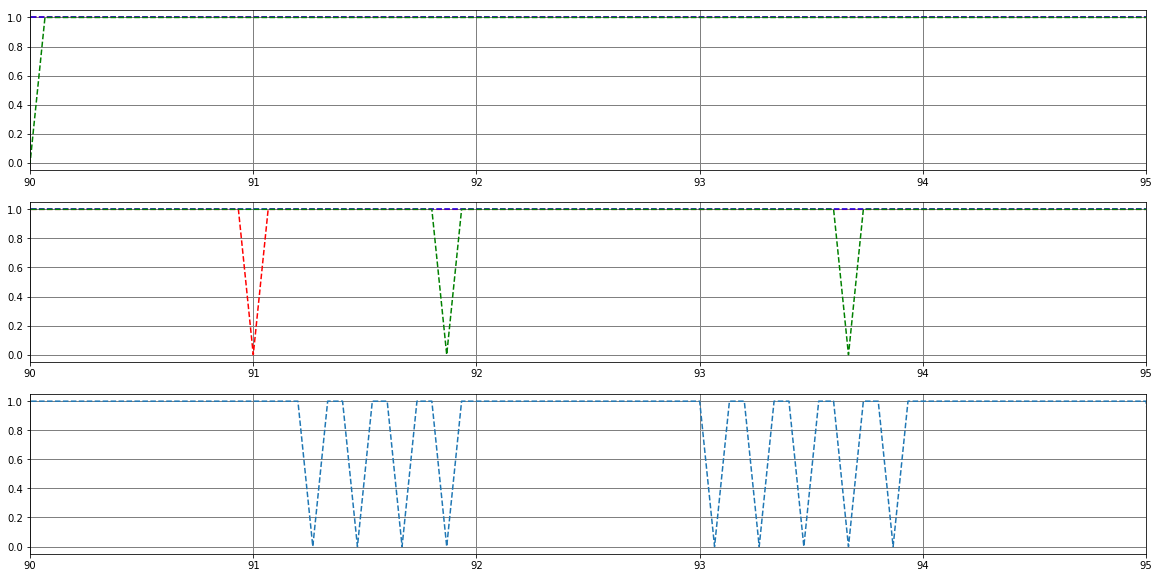

In [177]:
t = np.arange(0., len(test['mag_X']))/15

lim=(90,95)

ax = plt.subplot(3, 1, 1)
ax.plot(t, test['accel_X'], 'r--', t, test['accel_Y'], 'b--', t,test['accel_Z'], 'g--')
plt.xlim(lim[0],lim[1])
ax.grid(color='grey', linestyle='-', linewidth=1)

ax = plt.subplot(3, 1, 2)
ax.plot(t, test['mag_X'], 'r--', t, test['mag_Y'], 'b--', t,test['mag_Z'], 'g--')
plt.xlim(lim[0],lim[1])
ax.grid(color='grey', linestyle='-', linewidth=1)

ax = plt.subplot(3, 1, 3)
ax.plot(t,test['pressure'] , '--' )
plt.xlim(lim[0],lim[1])
ax.grid(color='grey', linestyle='-', linewidth=1)

ax.figure.set_size_inches(20,10)
plt.show()


In [186]:
# issue: the data is zero for all but the first values

# attemt for correction
lastvalid=dict()
names=('mag_X','mag_Y','mag_Z', 'accel_X', 'accel_Y', 'accel_Z', 'pressure')
for n in names:
    for i in range(len(data['mag_X'])):
        data[n][data[n]==0]=float('Nan')
        #if data[n][i]==0:
        #    if n in lastvalid.keys():
        #        data[n][i]=lastvalid[n]
        #else:
        #    lastvalid[n]=data[n][i]
            

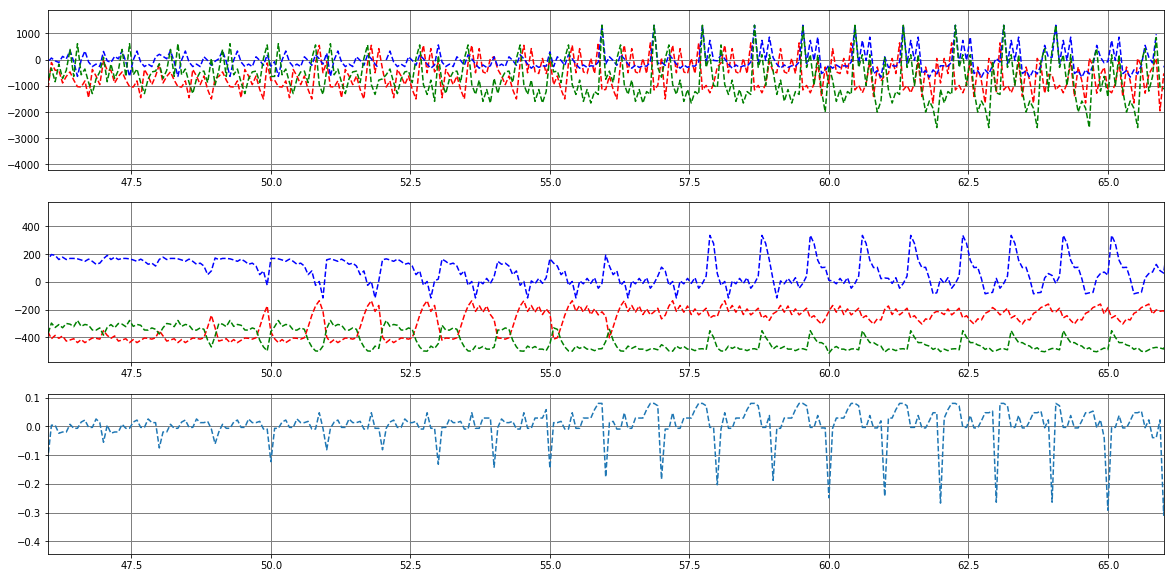

In [196]:
data['accel_X']
t = np.arange(0., len(data['delta']), 1/15)
dt=20
start=46
lim=(start,start+dt)

ax = plt.subplot(3, 1, 1)
ax.plot(t, data['accel_X'], 'r--', t, data['accel_Y'], 'b--', t,data['accel_Z'], 'g--')
plt.xlim(120,130)
plt.xlim(lim[0],lim[1])
ax.grid(color='grey', linestyle='-', linewidth=1)


ax = plt.subplot(3, 1, 2)
ax.plot(t, data['mag_X'], 'r--', t, data['mag_Y'], 'b--', t,data['mag_Z'], 'g--')
plt.xlim(0,22)
plt.xlim(lim[0],lim[1])
ax.grid(color='grey', linestyle='-', linewidth=1)


ax = plt.subplot(3, 1, 3)
mWS=9807 #Pa
amb_pressure=np.nanmedian(data['pressure'][0:150])
#amb_pressure=100000
depth=(amb_pressure-data['pressure'])/mWS*100
#ax.plot(t, (amb_pressure-data['pressure']),'--')
ax.plot(t,depth , '--' )
plt.xlim(lim[0],lim[1])
ax.grid(color='grey', linestyle='-', linewidth=1)

ax.figure.set_size_inches(20,10)
plt.show()


In [188]:

idx=np.arange(0, i+1)*15+data['gps_time']
idx[0]=0
col=np.array(["green", "red"])
cols=col[(depth[idx.astype(int)]< -.5).astype(int)]

plt.axis('equal')
plt.plot(  np.cumsum(data['delta_long']), np.cumsum(data['delta_lat']), '--')

plt.scatter(  np.cumsum(data['delta_long']), np.cumsum(data['delta_lat']), s=10,c=list(cols))
plt.show()

ValueError: operands could not be broadcast together with shapes (2205,) (147,) 

In [123]:
data.keys()

dict_keys(['accel_X', 'accel_Y', 'accel_Z', 'altitude', 'cadence', 'distance', 'enhanced_altitude', 'enhanced_speed', 'fractional_cadence', 'gps_accuracy', 'gps_lat', 'gps_lng', 'gps_time', 'heart_rate', 'mag_X', 'mag_Y', 'mag_Z', 'position_lat', 'position_long', 'pressure', 'section', 'speed', 'timestamp', 'unknown_87', 'unknown_88', 'position_lat_deg', 'position_long_deg', 'delta_lat', 'delta_long', 'delta'])

In [124]:
np.arange(0, i+1)*15+data['gps_time']

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [126]:
depth[idx.astype(int)]< -1

IndexError: index -9223372036854775808 is out of bounds for axis 1 with size 10485

In [127]:
["red", "blue"][(depth[idx.astype(int)]< -1).astype(int)]

IndexError: index -9223372036854775808 is out of bounds for axis 1 with size 10485

In [128]:
(depth[idx.astype(int)]< -1).astype(int)

IndexError: index -9223372036854775808 is out of bounds for axis 1 with size 10485